In [1]:
import geopandas as gpd
import pandas as pd
import s3fs
import numpy as np
import math
from shapely.geometry import Polygon, box
from sklearn.neighbors import KernelDensity
#import plotly.express as px
import matplotlib.pyplot as plt

# 1. Read Observation Data into Geopandas Frame

In [2]:
DATASET_PATH = '../data/full_dataset.csv'
RASTER_PATH = '../data/rasters/'

In [3]:

BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/observations'
train_file, test_file = 'observations_us_train.csv', 'observations_us_test.csv'
s3_train_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, train_file)

In [4]:
train_usa = pd.read_csv(s3_train_path,header='infer', sep=';',)
train_usa.head()

,observation_id,latitude,longitude,species_id,subset
0,20000173,33.197660,-116.180680,4911,train
1,20000175,34.037968,-118.876755,4912,train
2,20000176,27.620740,-97.222690,4913,train
3,20000177,29.155582,-95.653930,4914,train
4,20000179,36.605740,-121.959510,4915,train


In [5]:
train_df, val_df = train_usa[train_usa.subset == 'train'], train_usa[train_usa.subset == 'val']
len(train_df), len(val_df)

(931132, 25099)

In [6]:
del train_usa

In [7]:
train_gdf = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.longitude, train_df.latitude))\
                .drop(['latitude', 'longitude'], axis=1).set_crs(4326)
# train_gdf.to_crs
train_gdf.head()

,observation_id,species_id,subset,geometry
0,20000173,4911,train,POINT (-116.18068 33.19766)
1,20000175,4912,train,POINT (-118.87676 34.03797)
2,20000176,4913,train,POINT (-97.22269 27.62074)
3,20000177,4914,train,POINT (-95.65393 29.15558)
4,20000179,4915,train,POINT (-121.95951 36.60574)


In [8]:
train_df.latitude.max(), train_df.latitude.min(), train_df.longitude.max(), train_df.longitude.min()

(49.36043, 24.544977, -66.935905, -124.732956)

In [9]:
train_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 2. Create grid for USA (AOI)

In [10]:
## 2.1 Use a generic map outline for the USA

In [11]:
import geopandas as gpd
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot:>

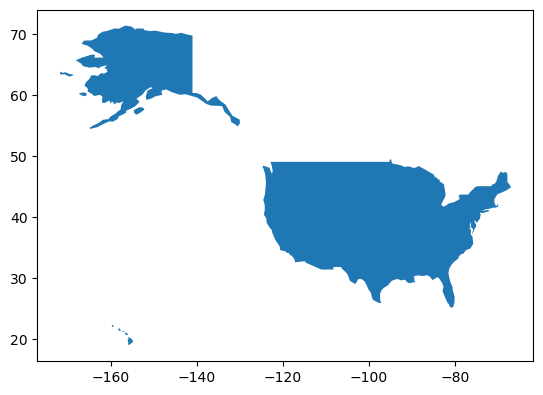

In [12]:
usa = world[world['name'] == 'United States of America']
usa.plot()

## 2.1 Now we only want continental USA, so clip to continental bounds

<AxesSubplot:>

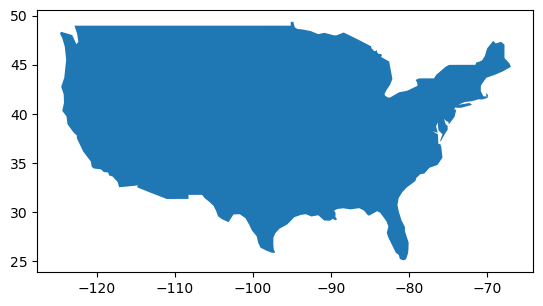

In [13]:
from shapely.geometry import Polygon

continental_bounds = Polygon([(-130,50), (-60,50), (-60,20), (-130,20)])
usa = usa.clip(continental_bounds)
usa.plot()

## 2.2 Dont Clip to continental boundaries (just yet)!

numpy needs rectangular arrays for it to work well

In [15]:
# grid_usa = grid_usa.clip(usa).reset_index(drop=True)

# fig, ax = plt.subplots(figsize=(10,10))
# grid_usa.plot(ax=ax, color = 'none', edgecolor = 'lightseagreen', alpha = 0.55)

In [14]:
grid_usa.crs

NameError: name 'grid_usa' is not defined

# 3. Species Level Kernel Function

## 3.1 Extract one species to test with

In [15]:
species_id_counts = train_df.species_id.value_counts()

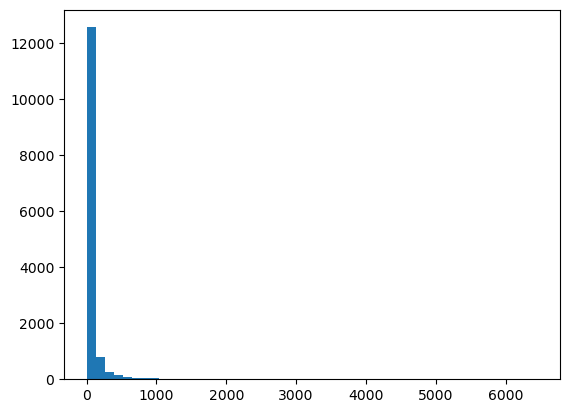

In [16]:
plt.hist(species_id_counts, bins=50)
plt.show()

In [19]:
species_id_counts[204:206]


115    723
523    721
Name: species_id, dtype: int64

## Build a class with all the data and functions needed for gridding and kernels

In [22]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
#Run this to reload the python file
%autoreload 2
from grid import Observations

In [175]:
obs_usa = Observations(train_gdf, total_bounds=usa.total_bounds, grid_res_deg=0.1)

580 246 (142680, 2)


In [168]:
obs_usa.grid_gd.loc[5510:5520].geometry.centroid

/tmp/ipykernel_964/2153824327.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  obs_usa.grid_gd.loc[5510:5520].geometry.centroid


5510    POINT (-122.53721 34.83000)
5511    POINT (-122.53721 34.93000)
5512    POINT (-122.53721 35.03000)
5513    POINT (-122.53721 35.13000)
5514    POINT (-122.53721 35.23000)
5515    POINT (-122.53721 35.33000)
5516    POINT (-122.53721 35.43000)
5517    POINT (-122.53721 35.53000)
5518    POINT (-122.53721 35.63000)
5519    POINT (-122.53721 35.73000)
5520    POINT (-122.53721 35.83000)
dtype: geometry

In [169]:
obs_usa.grid_np[5510:5521]

array([[-122.53721008,   34.83      ],
       [-122.53721008,   34.93      ],
       [-122.53721008,   35.03      ],
       [-122.53721008,   35.13      ],
       [-122.53721008,   35.23      ],
       [-122.53721008,   35.33      ],
       [-122.53721008,   35.43      ],
       [-122.53721008,   35.53      ],
       [-122.53721008,   35.63      ],
       [-122.53721008,   35.73      ],
       [-122.53721008,   35.83      ]])

### Combine chosen_species_grid into the primary observations grid with the following structures:

**Possibility A: Per observation**

| SpeciesID | Probability | GridID | Geometry |
| --- | --- | --- | --- |
| 115 | 0.7 | 7743 | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |


Or

**Possibility B: Per Grid**

| SpeciesID | SpeciesID | ... | SpeciesID | GridID | Geometry |
| --- | --- | --- | --- | --- | --- |
| 115 | 4443 | ... | 19328 | 52  | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |

We pick option A, since it provides a more memory efficient method

### Let's take species ID: 115, that has 723 observations across the USA

In [176]:
chosen_id = 115
kernel_115 = obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.0, kernel='gaussian', cumulative=False)

Max y_hat =  6.782616742449942
Shapes: X_train=(504, 2), y_train=(504,), arr_xy=(142680, 2), y_hat=(142680,), sum(y_hat)=30221.567033474552


In [171]:
kernel_115

,geometry,grid_id,prob_115
0,"POLYGON ((-124.68721 24.98000, -124.68721 25.0...",0,5.650353e-54
1,"POLYGON ((-124.68721 25.08000, -124.68721 25.1...",1,1.453730e-53
2,"POLYGON ((-124.68721 25.18000, -124.68721 25.2...",2,3.702961e-53
3,"POLYGON ((-124.68721 25.28000, -124.68721 25.3...",3,9.338381e-53
4,"POLYGON ((-124.68721 25.38000, -124.68721 25.4...",4,2.331584e-52
...,...,...,...
142675,"POLYGON ((-66.78721 49.08000, -66.78721 49.180...",142675,1.047878e-13
142676,"POLYGON ((-66.78721 49.18000, -66.78721 49.280...",142676,5.503930e-14
142677,"POLYGON ((-66.78721 49.28000, -66.78721 49.380...",142677,2.863746e-14
142678,"POLYGON ((-66.78721 49.38000, -66.78721 49.480...",142678,1.475975e-14


In [172]:
kernel_115 = kernel_115.clip(usa).reset_index(drop=True)

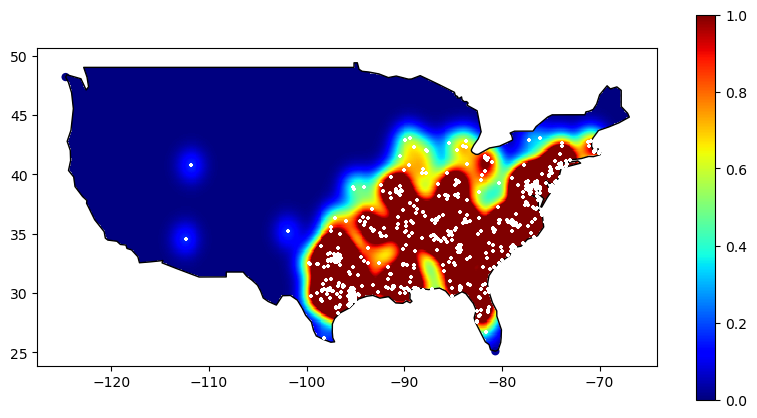

In [165]:
col_name = 'prob_{}'.format(chosen_id)
fig, ax = plt.subplots(figsize=(10,10))
kernel_115.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

### Let's do one more and make it cumulative

In [178]:
chosen_id = 4911
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.3, kernel='epanechnikov', cumulative=True)


Max y_hat =  3.1454290528220716
Shapes: X_train=(7, 2), y_train=(7,), arr_xy=(142680, 2), y_hat=(142680,), sum(y_hat)=785.4197183804981


In [183]:
chosen_id = 46
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=2.0, kernel='linear', cumulative=True)

Max y_hat =  23.07530945701777
Shapes: X_train=(192, 2), y_train=(192,), arr_xy=(142680, 2), y_hat=(142680,), sum(y_hat)=30595.411890868647


In [184]:
obs_usa.grid_kde

,geometry,grid_id,prob_115,prob_4911,prob_46
0,"POLYGON ((-124.68721 24.98000, -124.68721 25.0...",0,5.650353e-54,0.0,0.0
1,"POLYGON ((-124.68721 25.08000, -124.68721 25.1...",1,1.453730e-53,0.0,0.0
2,"POLYGON ((-124.68721 25.18000, -124.68721 25.2...",2,3.702961e-53,0.0,0.0
3,"POLYGON ((-124.68721 25.28000, -124.68721 25.3...",3,9.338381e-53,0.0,0.0
4,"POLYGON ((-124.68721 25.38000, -124.68721 25.4...",4,2.331584e-52,0.0,0.0
...,...,...,...,...,...
142675,"POLYGON ((-66.78721 49.08000, -66.78721 49.180...",142675,1.047878e-13,0.0,0.0
142676,"POLYGON ((-66.78721 49.18000, -66.78721 49.280...",142676,5.503930e-14,0.0,0.0
142677,"POLYGON ((-66.78721 49.28000, -66.78721 49.380...",142677,2.863746e-14,0.0,0.0
142678,"POLYGON ((-66.78721 49.38000, -66.78721 49.480...",142678,1.475975e-14,0.0,0.0


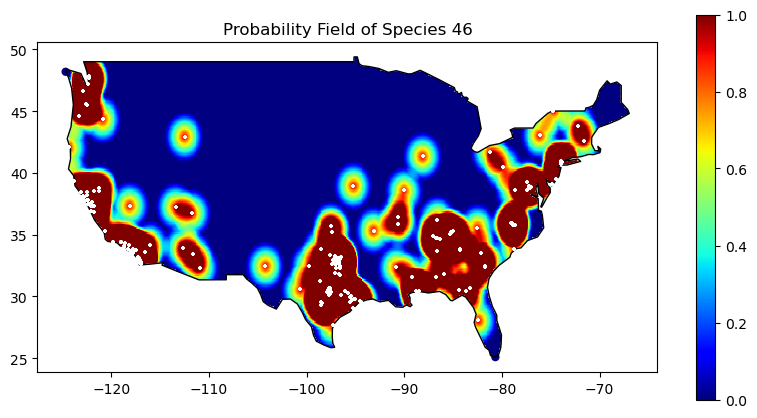

In [186]:
kernels = obs_usa.grid_kde.clip(usa).reset_index(drop=True)

col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
ax.set_title('Probability Field of Species {}'.format(chosen_id))
plt.show()

In [182]:
len(train_gdf[train_gdf.species_id==46])

289